This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
import pandas as pd # standard naming convention
import numpy as np
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [25]:
file_name = "data_000637.txt"
data = pd.read_csv(file_name)
N=150000
data_N=data.head(N)
data_N

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
149995,1,1,108,3869201660,1085,11
149996,1,1,103,3869201660,1085,5
149997,1,1,105,3869201660,1088,19
149998,1,1,104,3869201660,1095,15


2\. Estimate the number of BX in a ORBIT (the value 'x').

In [3]:

x=max(data_N['BX_COUNTER'])+1     # I added 1 because for example 60 min = 1 h  and I would have found 59 min as a max value 
print('the ORBIT_CNT is increased every ',x,' BX_COUNTER')

the ORBIT_CNT is increased every  3564  BX_COUNTER


3\. Find out the duration of the data taking in hours, minutes and seconds. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading the whole dataset.

In [4]:
duration=(data_N['ORBIT_CNT'][N-1]-data_N['ORBIT_CNT'][0])*25*10**-9*x    #rough estimation, but a better result is achived in the next point

print('the duration of the data acquisition is ',duration,'seconds')
print('the duration of the data acquisition is ',duration/60,'minutes')
print('the duration of the data acquisition is ',duration/3600,'hours')

the duration of the data acquisition is  0.1330263 seconds
the duration of the data acquisition is  0.0022171049999999996 minutes
the duration of the data acquisition is  3.695175e-05 hours


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition.

In [5]:
time=[]
time.append(0)
t0=(data_N['TDC_MEAS'][0]*(25/30)+data_N['BX_COUNTER'][0]*25+data_N['ORBIT_CNT'][0]*x*25)  #time zero in ns
print('the inizial time t0 is',t0*10**-9,'[ns]')
for i in range(1,N):
    t=data_N['TDC_MEAS'][i]*(25/30)+data_N['BX_COUNTER'][i]*25+data_N['ORBIT_CNT'][i]*x*25
    time.append(t-t0)
#print(time)
total_time=max(time)*10**-9

print('the total time of data acquisition in seconds is', total_time,'[s]')
#this is clearly higher since here I consider the difference of BX_COUNTER and TDC_MEAS too, but the difference is not so large since they are very small fractions of ORBIT_CNT
#data_N['absolute time']=time
data_N.insert(6, "absolute time [ns]",time, True)
data_N

the inizial time t0 is 344745.7349390717 [ns]
the total time of data acquisition in seconds is 0.1329943158125 [s]


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,absolute time [ns]
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.125000e-01
2,1,0,63,3869200167,2553,28,4.476625e+03
3,1,0,64,3869200167,2558,19,4.594125e+03
4,1,0,64,3869200167,2760,25,9.649125e+03
...,...,...,...,...,...,...,...
149995,1,1,108,3869201660,1085,11,1.329941e+08
149996,1,1,103,3869201660,1085,5,1.329941e+08
149997,1,1,105,3869201660,1088,19,1.329941e+08
149998,1,1,104,3869201660,1095,15,1.329943e+08


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [9]:
noise=data_N.groupby('TDC_CHANNEL')
noise.size().nlargest(3)
#noise.size()

TDC_CHANNEL
139    12478
64      7452
63      7329
dtype: int64

6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit). Count also the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [46]:
unique_f = data_N['ORBIT_CNT'].count()
#print(unique_f.shape)
print('the number of non-empty orbits is:',unique_f)

tmp1=data_N.query('TDC_CHANNEL==139')
#print(tmp1.shape)  that's 12478, coherent with the previous result from groupby

unique = tmp1.drop_duplicates(subset=['ORBIT_CNT'], keep="first")
print('the number of non-empty orbits with TDC_CHANNEL=139 is:',unique.shape[0])

the number of non-empty orbits is: 150000
the number of non-empty orbits with TDC_CHANNEL=139 is: 1490


7\. **Optional:** Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

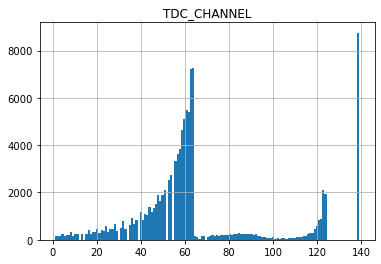

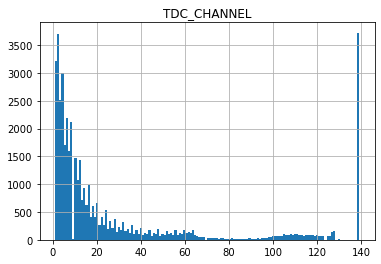

In [88]:
import matplotlib.pyplot as plt
data_N.query('FPGA==0').hist('TDC_CHANNEL',bins=140)      # filtering according to the FPGA and then create the histogram with the TDC_CHANNEL
data_N.query('FPGA==1').hist('TDC_CHANNEL',bins=140)
plt.show()